Inpainting using Sparse Regularization
======================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explores the use of
sparse energies to regularize the image inpaiting problem.

In [2]:
using PyPlot
using NtToolBox
# using Autoreload
# arequire("NtToolBox")

Here we consider inpainting of damaged observation without noise.

Sparse Regularization
---------------------
This tour consider measurements $y=\Phi f_0 + w$
where $\Phi$ is a masking operator
and $w$ is an additive noise.


This tour is focused on using sparsity to recover an image from the
measurements $y$. It considers a synthesis-based regularization, that
compute a sparse set of coefficients $ (a_m^{\star})_m $
in a frame $\Psi = (\psi_m)_m$ that solves
$$a^{\star} \in \text{argmin}_a \: \frac{1}{2}\|y-\Phi \Psi a\|^2 + \lambda J(a)$$


where $\lambda$ should be adapted to the noise level $\|w\|$.
Since in this tour we consider damaged observation without noise, i.e.
$w=0$, we use either a very small value of $\lambda$, or we decay its
value through the iterations of the recovery process.


Here we use the notation
$$\Psi a = \sum_m a_m \psi_m$$
to indicate the reconstruction operator, and $J(a)$ is the $\ell^1$
sparsity prior
$$J(a)=\sum_m \|a_m\|.$$


Missing Pixels and Inpainting
-----------------------------
Inpainting corresponds to filling holes in images.
This corresponds to a linear ill posed inverse problem.


You might want to do first the numerical tour _Variational image inpaiting_
that use Sobolev and TV priors to performs the inpainting.


First we load the image to be inpainted.

In [3]:
n = 128
f0 = load_image("NtToolBox/src/data/lena.png")
f0 = rescale(f0[256 - Base.div(n, 2) + 1 : 256 + Base.div(n, 2), 256 - Base.div(n, 2) + 1 : 256 + Base.div(n, 2)]);

Display it.

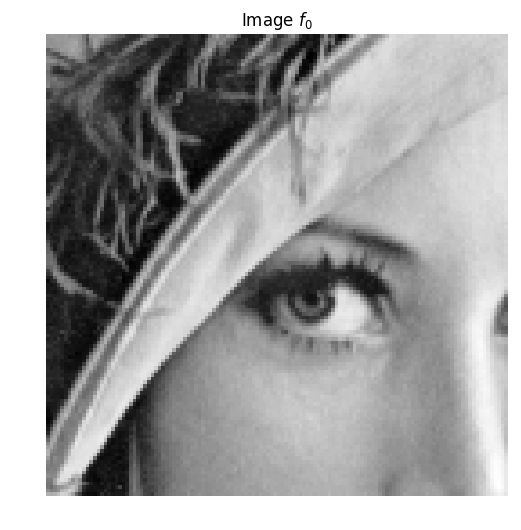

PyObject <matplotlib.text.Text object at 0x000000002566FA58>

In [39]:
figure(figsize = (6, 6))
imageplot(f0, L"Image $f_0$")

Amount of removed pixels.

In [40]:
rho = .7;

0.7

Then we construct a mask $\Omega$ made of random pixel locations.

In [41]:
Omega = zeros(n, n)
sel = randperm(n^2)
Omega[sel[1:Int(round(rho*n^2))]] = 1;

1

The damaging operator put to zeros the pixel locations $x$ for which $\Omega(x)=1$

In [42]:
Phi = (f, Omega) -> f.*(1 - Omega);

(::#21) (generic function with 1 method)

The damaged observations reads $y = \Phi f_0$.

In [43]:
y = Phi(f0, Omega);

128×128 Array{Float64,2}:
 0.0       0.0       0.0       0.596059  …  0.817734  0.0       0.0     
 0.571429  0.0       0.591133  0.610838     0.0       0.0       0.812808
 0.581281  0.0       0.0       0.0          0.0       0.0       0.0     
 0.561576  0.0       0.0       0.586207     0.0       0.802956  0.0     
 0.0       0.0       0.522168  0.0          0.0       0.0       0.82266 
 0.0       0.0       0.0       0.0       …  0.0       0.802956  0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.561576  0.0       0.0          0.0       0.82266   0.0     
 0.472906  0.0       0.0       0.394089     0.0       0.0       0.0     
 0.0       0.0       0.0       0.182266     0.0       0.0       0.0     
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.832512
 0.44335   0.0       0.0       0.0          0.0       0.812808  0.0     
 0.0       0.0       0.0       0.369458     0.807882  0.0       0.827586
 ⋮                       

Display the observations.

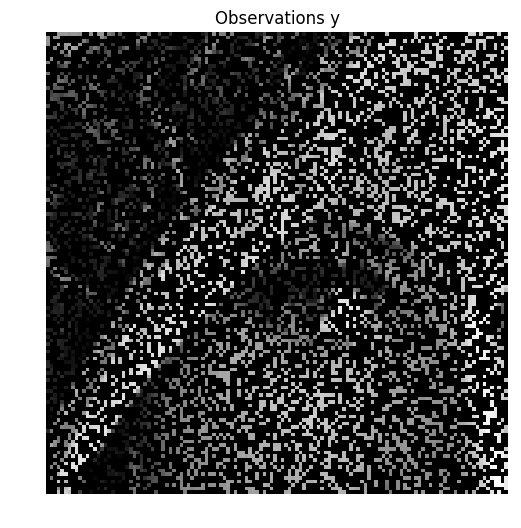

PyObject <matplotlib.text.Text object at 0x0000000025309A90>

In [44]:
figure(figsize = (6, 6))
imageplot(y, "Observations y")

Soft Thresholding in a Basis
----------------------------
The soft thresholding operator is at the heart of $\ell^1$ minimization
schemes. It can be applied to coefficients $a$, or to an image $f$
in an ortho-basis.


The soft thresholding is a 1-D functional that shrinks the value of
coefficients.
$$ s_T(u)=\max(0,1-T/|u|)u $$


Define a shortcut for this soft thresholding 1-D functional.

In [45]:
SoftThresh = (x,T) -> x.*max( 0, 1 - T./max(abs(x), 1e-10) );

(::#23) (generic function with 1 method)

Display a curve of the 1D soft thresholding.

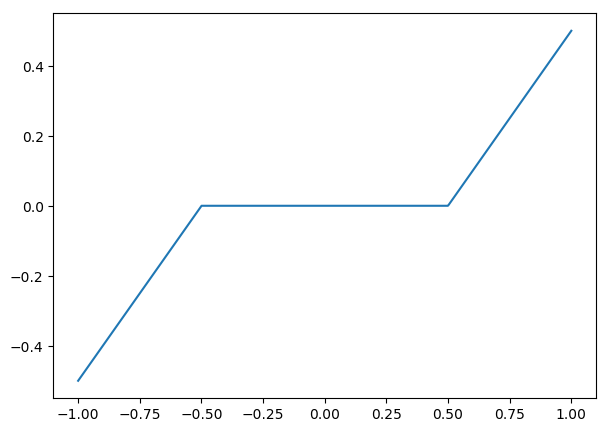

In [46]:
x = linspace(-1, 1, 1000)

figure(figsize = (7, 5))
plot(x, SoftThresh(x, .5))
show()

Note that the function SoftThresh can also be applied to vector which defines an
operator on coefficients:
$$ S_T(a) = ( s_T(a_m) )_m. $$


In the next section, we use an orthogonal wavelet basis $\Psi$.


We set the parameters of the wavelet transform.

In [47]:
Jmax = log2(n) - 1
Jmin = (Jmax - 3);

3.0

Shortcut for $\Psi$ and $\Psi^*$ in the orthogonal case.

In [48]:
Psi = a -> NtToolBox.perform_wavelet_transf(a, Jmin, -1, "9-7", 0, 0)
PsiS = f -> NtToolBox.perform_wavelet_transf(f, Jmin, +1, "9-7", 0, 0);

The soft thresholding opterator in the basis $\Psi$ is defined as
$$S_T^\Psi(f) = \sum_m s_T( \langle f,\psi_m \rangle ) \psi_m $$


It thus corresponds to applying the transform $\Psi^*$, thresholding
the coefficients using $S_T$ and then undoing the transform using
$\Psi$.
$$ S_T^\Psi(f) = \Psi \circ S_T \circ \Psi^*$$

In [49]:
SoftThreshPsi = (f, T) -> Psi(SoftThresh(PsiS(f), T));

This soft thresholding corresponds to a denoising operator.

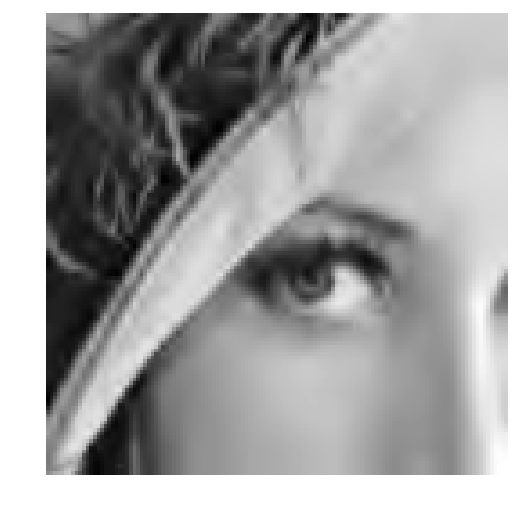

In [50]:
figure(figsize = (6, 6))
imageplot(clamP(SoftThreshPsi(f0, 0.1)))

Inpainting using Orthogonal Wavelet Sparsity
--------------------------------------------
If $\Psi$ is an orthogonal basis, a change of variable shows that the
synthesis prior is also an analysis prior, that reads
$$f^{\star} \in \text{argmin}_f \: E(f) = \frac{1}{2}\|y-\Phi f\|^2 + \lambda \sum_m \|\langle f,\psi_m \rangle\|. $$


To solve this non-smooth optimization problem, one can use
forward-backward splitting, also known as iterative soft thresholding.


It computes a series of images $f^{(\ell)}$ defined as
$$ f^{(\ell+1)} = S_{\tau\lambda}^{\Psi}( f^{(\ell)} - \tau \Phi^{*} (\Phi f^{(\ell)} - y)  ) $$


Set up the value of the threshold.

In [52]:
lambd = .03;

In our setting, we have $ \Phi^* = \Phi $ which is an operator of norm
1.


For $f^{(\ell)}$ to converge to a solution of the problem, the gradient
step size should be chosen as
$$\tau < \frac{2}{\|\Phi^* \Phi\|} = 2$$


In the following we use:
$$\tau = 1$$


Since we use $ \tau=1 $ and $ \Phi = \Phi^* = \text{diag}(1-\Omega) $,  the gradient descent step
is a projection on the inpainting constraint
$$ C = \{ f \backslash \forall \Omega(x)=0, f(x)=y(x) \} $$
One thus has
$$ f - \tau \Phi^{*} (\Phi f - y)  = \text{Proj}_C(f) $$


For the sake of simplicity, we define a shortcut for this projection
operator.

In [53]:
ProjC = (f, Omega) -> Omega.*f + (1 - Omega).*y;

Each iteration of the forward-backward (iterative thresholding) algorithm
thus reads:
$$ f^{(\ell+1)} = S_{\lambda}^\Psi( \text{Proj}_C(f^{(\ell)}) ). $$


Initialize the iterations.

In [54]:
fSpars = y;

First step: gradient descent.

In [55]:
fSpars = ProjC(fSpars, Omega);

Second step: denoise the solution by thresholding.

In [56]:
fSpars = SoftThreshPsi(fSpars, lambd);

__Exercise 1__

Perform the iterative soft thresholding.
Monitor the decay of the energy $E$ you are minimizing.

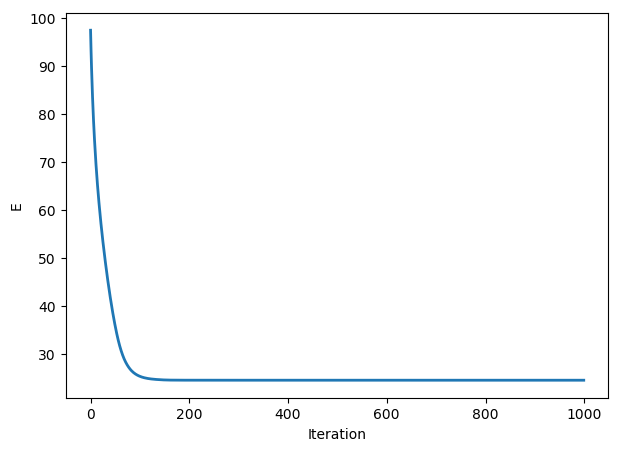

In [57]:
include("NtSolutions/inverse_5_inpainting_sparsity/exo1.jl")

In [21]:
## Insert your code here.

Display the result.

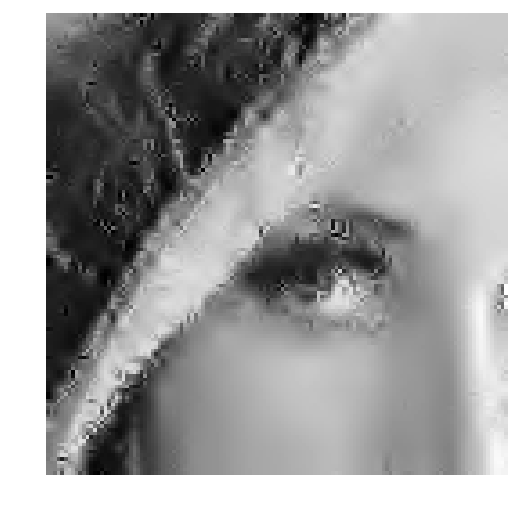

In [58]:
figure(figsize = (6, 6))
imageplot(clamP(fSpars))

__Exercise 2__

Since there is no noise, one should in theory take $\lambda
\rightarrow 0$.
To do this, decay the value of $\lambda$ through the iterations.

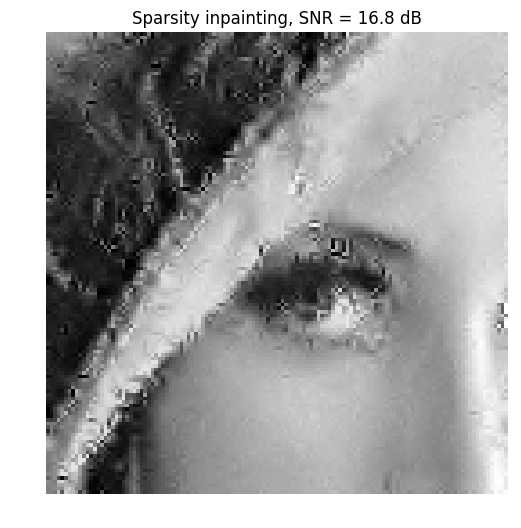

PyObject <matplotlib.text.Text object at 0x0000000024F89518>

In [59]:
include("NtSolutions/inverse_5_inpainting_sparsity/exo2.jl")

In [24]:
## Insert your code here.

Inpainting using Translation Invariant Wavelet Sparsity
-------------------------------------------------------
Orthogonal sparsity performs a poor regularization because of the lack of
translation invariance. This regularization is enhanced by considering
$\Psi$ as a redundant tight frame of translation invariant wavelets.


One thus looks for optimal coefficients $a^\star$ that solves
$$a^{\star} \in \text{argmin}_a \: E(a) = \frac{1}{2}\|y-\Phi \Psi a\|^2 + \lambda J(a)$$


*Important*: The operator $\Psi^*$ is the forward translation invariant wavelet transform.
It computes the inner product with the unit norm wavelet atoms:
$$ (\Psi^* f)_m = \langle f,\psi_m \rangle \quad \text{with} \quad \|\psi_m\|=1. $$


The reconstruction operator $\Xi$ satisfies $ \Xi \Psi^* f = f $, and
is the pseudo inverse of the analysis operator $ \Xi = (\Psi^*)^+ $.


For our algorithm, we will need to use $\Psi$ and not $\Xi$. Lukily,
for the wavelet transform, one has
$$ \Xi = \Psi \text{diag(U)} f $$
where $U_m$ account for the redundancy of the scale of the atom
$\psi_m$.


Compute the scaling factor (inverse of the redundancy).

In [68]:
J = Jmax - Jmin + 1;

u = reshape([4^(-J); 4.^(-floor(J+2/3:-1/3:1))], (1, 1, 13))

U = repeat(u, inner = [n, n, 1])


128×128×13 Array{Float64,3}:
[:, :, 1] =
 0.00390625  0.00390625  0.00390625  …  0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625  …  0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625  …  0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390625  0.00390625
 0.00390625  0.00390625  0.00390625     0.00390625  0.00390

Choose a value of the regularization parameter.

In [70]:
lambd = .01;

0.01

Shortcut for the wavelet transform and the reconstruction.



*Important:* Scilab users have to create files |Xi.m|, |PsiS.m| and |Psi.m| to implement this
function.

In [71]:
Xi = a -> NtToolBox.perform_wavelet_transf(a, Jmin, -1, "9-7", 0, 1)
PsiS = f -> NtToolBox.perform_wavelet_transf(f, Jmin, + 1, "9-7", 0, 1)
Psi = a -> Xi(a./U);

The forward-backward algorithm now compute a series of wavelet
coefficients $a^{(\ell)}$ computed as
$$a^{(\ell+1)} = S_{\tau\lambda}( a^{(\ell)} + \Psi^*\Phi( y - \Phi\Psi a^{(\ell)} )  ). $$


The soft thresholding is defined as:
$$\forall m, \quad S_T(a)_m = \max(0, 1-T/\|a_m\|)a_m. $$


The step size should satisfy:
$$\tau < \frac{2}{\|\Psi\Phi \|} \leq 2 \min( u ). $$

In [72]:
tau = 1.9*minimum(u);

0.007421875

Initialize the wavelet coefficients with those of the previous reconstruction.

In [119]:
a = U.*PsiS(fSpars) ;

128×128×13 Array{Float64,3}:
[:, :, 1] =
 0.0323998  0.0323408  0.032198   …  0.0497627  0.0497896  0.0498026
 0.0323222  0.0322629  0.0321195     0.049747   0.0497735  0.0497863
 0.0320984  0.0320383  0.0318918     0.0497036  0.0497298  0.0497425
 0.031718   0.0316577  0.0315087     0.0496433  0.0496698  0.0496825
 0.0311659  0.0311074  0.0309599     0.0495708  0.0495982  0.0496111
 0.0304433  0.0303877  0.0302443  …  0.0494936  0.0495219  0.0495349
 0.0295714  0.0295197  0.0293834     0.0494165  0.0494451  0.049458 
 0.0285937  0.0285468  0.0284203     0.0493344  0.0493626  0.0493751
 0.0275173  0.0274758  0.0273607     0.0492568  0.0492838  0.0492956
 0.026379   0.0263437  0.0262417     0.0491961  0.0492221  0.0492333
 0.0252068  0.0251783  0.0250907  …  0.0491663  0.0491926  0.0492036
 0.0239974  0.0239752  0.0239017     0.0491732  0.0492007  0.0492117
 0.0227982  0.022781   0.0227206     0.0492064  0.0492362  0.049248 
 ⋮                                ⋱  ⋮                        

Gradient descent.

In [120]:
fTI = Psi(a)
a = a + tau.*PsiS(Phi(y-Phi(fTI, Omega), Omega));

128×128×13 Array{Float64,3}:
[:, :, 1] =
 0.0323998  0.0323408  0.032198   …  0.0497627  0.0497896  0.0498026
 0.0323222  0.0322629  0.0321195     0.049747   0.0497735  0.0497863
 0.0320984  0.0320383  0.0318918     0.0497036  0.0497298  0.0497425
 0.031718   0.0316577  0.0315087     0.0496433  0.0496698  0.0496825
 0.0311659  0.0311074  0.0309599     0.0495708  0.0495982  0.0496111
 0.0304433  0.0303877  0.0302443  …  0.0494936  0.0495219  0.0495349
 0.0295714  0.0295197  0.0293834     0.0494165  0.0494451  0.049458 
 0.0285937  0.0285468  0.0284203     0.0493344  0.0493626  0.0493751
 0.0275173  0.0274758  0.0273607     0.0492568  0.0492838  0.0492956
 0.026379   0.0263437  0.0262417     0.0491961  0.0492221  0.0492333
 0.0252068  0.0251783  0.0250907  …  0.0491663  0.0491926  0.0492036
 0.0239974  0.0239752  0.0239017     0.0491732  0.0492007  0.0492117
 0.0227982  0.022781   0.0227206     0.0492064  0.0492362  0.049248 
 ⋮                                ⋱  ⋮                        

Soft threshold.

In [121]:
a = SoftThresh(a, lambd*tau);

128×128×13 Array{Float64,3}:
[:, :, 1] =
 0.0323256  0.0322666  0.0321238  …  0.0496885  0.0497154  0.0497284
 0.032248   0.0321887  0.0320453     0.0496728  0.0496992  0.0497121
 0.0320242  0.0319641  0.0318176     0.0496294  0.0496555  0.0496682
 0.0316437  0.0315835  0.0314344     0.0495691  0.0495955  0.0496082
 0.0310917  0.0310332  0.0308857     0.0494966  0.049524   0.0495368
 0.0303691  0.0303135  0.0301701  …  0.0494194  0.0494477  0.0494607
 0.0294972  0.0294455  0.0293092     0.0493423  0.0493709  0.0493838
 0.0285195  0.0284726  0.0283461     0.0492602  0.0492884  0.0493009
 0.0274431  0.0274016  0.0272865     0.0491826  0.0492095  0.0492214
 0.0263047  0.0262695  0.0261674     0.0491219  0.0491479  0.0491591
 0.0251326  0.0251041  0.0250165  …  0.0490921  0.0491183  0.0491293
 0.0239232  0.0239009  0.0238275     0.049099   0.0491264  0.0491375
 0.0227239  0.0227068  0.0226463     0.0491322  0.049162   0.0491738
 ⋮                                ⋱  ⋮                        

__Exercise 3__

Perform the iterative soft thresholding. Monitor the decay of the
energy $E$.

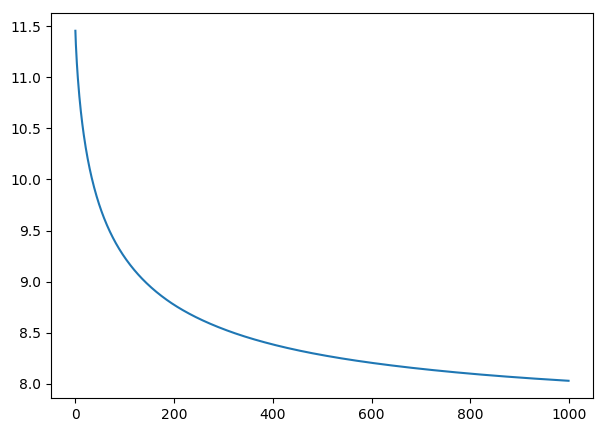

In [122]:
include("NtSolutions/inverse_5_inpainting_sparsity/exo3.jl")

# niter = 1000
# a = U.*PsiS(fSpars)
# E = []
# for i in 1 : niter
#     fTI = Psi(a)
#     d = y - Phi(fTI, Omega)
#     E = [E; 1/2.*vecnorm(d )^2 + lambd*sum(abs(a))]
#     # step 
#     a = SoftThresh(a + tau.*PsiS(Phi(d, Omega)), lambd*tau)
# end

# figure(figsize = (7, 5))    
# plot(E)
# show()

In [33]:
## Insert your code here.

Perform the reconstruction.

In [123]:
fTI = Psi(a);

128×128 Array{Float64,2}:
 0.5959    0.595353  0.595991  0.599185  …  0.807213  0.808388  0.808516
 0.584907  0.588184  0.595149  0.599971     0.806676  0.808078  0.808128
 0.57642   0.578371  0.584624  0.59133      0.805662  0.80676   0.80688 
 0.553808  0.557782  0.563702  0.575164     0.804513  0.804783  0.806422
 0.526524  0.527638  0.531838  0.545507     0.802583  0.805117  0.810185
 0.515926  0.507072  0.512286  0.511787  …  0.801578  0.802938  0.805109
 0.535189  0.514696  0.511119  0.498153     0.797553  0.801766  0.801545
 0.490022  0.548615  0.486463  0.4634       0.799584  0.809141  0.811728
 0.476114  0.453588  0.431169  0.393877     0.798867  0.803229  0.803014
 0.426983  0.410282  0.35747   0.199237     0.797629  0.803465  0.808521
 0.416674  0.400481  0.384433  0.374821  …  0.796928  0.805276  0.816949
 0.429307  0.413717  0.373537  0.33173      0.801037  0.811888  0.804466
 0.385212  0.386148  0.384318  0.368313     0.803085  0.809197  0.817707
 ⋮                       

Display the result.

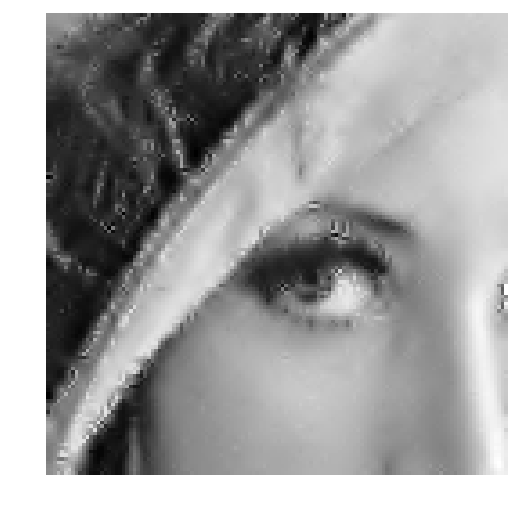

In [124]:
figure(figsize = (6, 6))
imageplot(clamP(fTI))

__Exercise 4__

Perform the iteration with a decaying value of $\lambda$

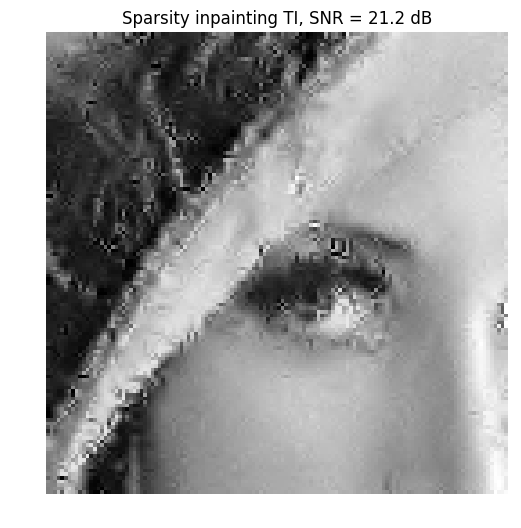

PyObject <matplotlib.text.Text object at 0x0000000025B44048>

In [125]:
include("NtSolutions/inverse_5_inpainting_sparsity/exo4.jl")

In [37]:
## Insert your code here.

Inpainting using Iterative Hard Thresholding
--------------------------------------------
To improve the sparsity of the solution, it is possible to replace the
soft thresholding by a hard threshdoling. In this case, the resulting
algorihtm does not perform anymore a variational minimization of an
energy.


The hard thresholding is defined as $h_T(x)=0$ if $-T < x < T$
and $h_T(x)=x$ otherwise. It thus defines a thresholding operator of
wavelet coefficients as $H_T(a)_m = h_T(a_m)$.


Define a shortcut for this vectorialized hard thresholding



*Important:* Scilab users have to create a file |HardThresh.m| to implement this
function.

In [126]:
HardThresh = (x, t) -> x.*(abs(x) .> t)

(::#103) (generic function with 1 method)

Display a curve of the 1-D Hard thresholding.

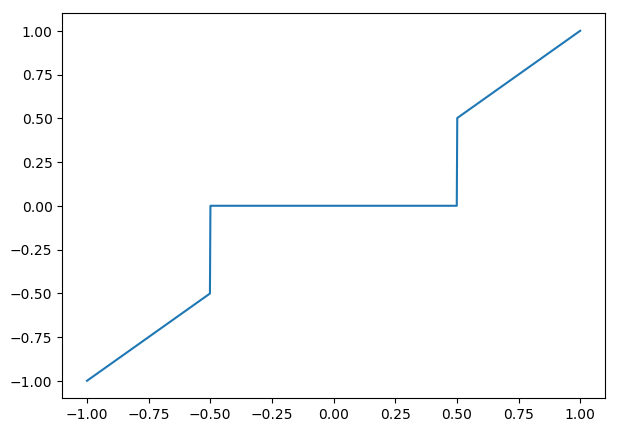

In [127]:
x = linspace(-1, 1, 1000)

figure(figsize = (7, 5))
plot(x, HardThresh(x, .5))
show()

The hard thresholding in the translation invariant wavelet basis $\Psi$
reads
$$ H_T^\Psi(f) = \Xi \circ H_T \circ \Psi^* (f) $$
where $\Xi = (\Phi^*)^+$ is the reconstruction operator.


We follow the MCA paradigm of Jean-Luc Starck, that alternates between a
gradient descent step and a hard thresholding denoising, using a decaying
threshold.
$$f^{(\ell+1)} = H_{\tau\lambda_\ell}^\Psi( f^{(\ell)} - \tau \Phi^*(\Phi f^{(\ell)} - y)  ). $$


Number of iterations.

In [128]:
niter = 500

500

List of thresholds. One must start by a large enough initial threshold.

In [129]:
lambda_list = linspace(1, 0, niter)

500-element LinSpace{Float64}:
 1.0,0.997996,0.995992,0.993988,…,0.00601202,0.00400802,0.00200401,0.0

Initialization.

In [130]:
fHard = y

128×128 Array{Float64,2}:
 0.0       0.0       0.0       0.596059  …  0.817734  0.0       0.0     
 0.571429  0.0       0.591133  0.610838     0.0       0.0       0.812808
 0.581281  0.0       0.0       0.0          0.0       0.0       0.0     
 0.561576  0.0       0.0       0.586207     0.0       0.802956  0.0     
 0.0       0.0       0.522168  0.0          0.0       0.0       0.82266 
 0.0       0.0       0.0       0.0       …  0.0       0.802956  0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.561576  0.0       0.0          0.0       0.82266   0.0     
 0.472906  0.0       0.0       0.394089     0.0       0.0       0.0     
 0.0       0.0       0.0       0.182266     0.0       0.0       0.0     
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.832512
 0.44335   0.0       0.0       0.0          0.0       0.812808  0.0     
 0.0       0.0       0.0       0.369458     0.807882  0.0       0.827586
 ⋮                       

Gradient descent.

In [131]:
fHard = ProjC(fHard, Omega)

128×128 Array{Float64,2}:
 0.0       0.0       0.0       0.596059  …  0.817734  0.0       0.0     
 0.571429  0.0       0.591133  0.610838     0.0       0.0       0.812808
 0.581281  0.0       0.0       0.0          0.0       0.0       0.0     
 0.561576  0.0       0.0       0.586207     0.0       0.802956  0.0     
 0.0       0.0       0.522168  0.0          0.0       0.0       0.82266 
 0.0       0.0       0.0       0.0       …  0.0       0.802956  0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.561576  0.0       0.0          0.0       0.82266   0.0     
 0.472906  0.0       0.0       0.394089     0.0       0.0       0.0     
 0.0       0.0       0.0       0.182266     0.0       0.0       0.0     
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.832512
 0.44335   0.0       0.0       0.0          0.0       0.812808  0.0     
 0.0       0.0       0.0       0.369458     0.807882  0.0       0.827586
 ⋮                       

Hard threshold (here $\lambda=\lambda_0$) is used).

In [132]:
fHard = Xi(HardThresh(PsiS(fHard), tau*lambda_list[1]));

128×128 Array{Float64,2}:
  3.66494e-5    0.000114282   3.83719e-5   …   1.48864e-5   -1.52949e-5 
  0.571531     -9.20383e-5    0.591257        -2.28221e-5    0.812817   
  0.581632     -0.000467075   0.000137072     -4.51812e-5    3.25829e-6 
  0.560358      0.000902527  -0.000436964      0.802976     -6.8564e-5  
  0.000264716  -0.000460029   0.522475         0.000223522   0.822554   
 -4.61803e-5   -0.000139511   0.00022262   …   0.802417      0.000101539
 -0.000100566  -2.66475e-5    6.36337e-7       0.00029115   -6.52386e-5 
  4.16665e-5    0.561575     -0.000171974      0.822604     -7.24068e-5 
  0.472961     -1.94345e-5   -9.283e-5        -0.000170705  -0.000214937
 -6.30669e-5   -1.12377e-5    3.03863e-5      -0.000520495  -0.000549995
 -2.24487e-6   -6.98895e-5    0.000103071  …   0.00121376    0.833889   
  0.44338      -5.18721e-6    0.000131892      0.812257     -0.000614638
 -0.00046031    0.00051018   -6.4683e-5       -0.000247252   0.827269   
  ⋮                      

__Exercise 5__

Perform the iteration with a decaying value of $\lambda$

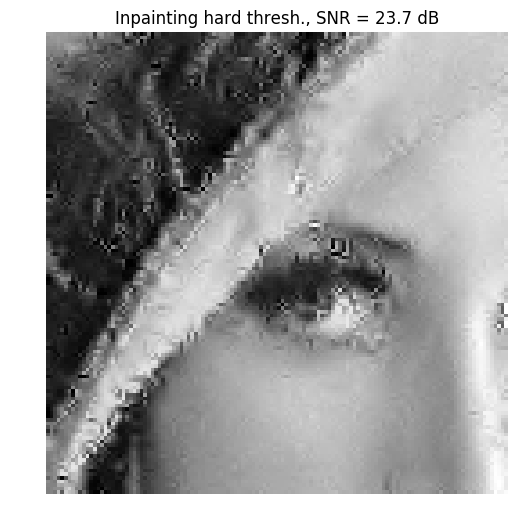

PyObject <matplotlib.text.Text object at 0x0000000025A10B00>

In [133]:
include("NtSolutions/inverse_5_inpainting_sparsity/exo5.jl")

# lambda_list = linspace(1, 0, niter)
# fHard = y

# for i in 1 : niter
#     fHard = Xi(HardThresh(PsiS(ProjC(fHard, Omega)), lambda_list[i]))
# end

    
# figure(figsize = (6, 6))
# imageplot(clamP(fSpars), @sprintf("Inpainting hard thresh., SNR = %.1f dB", snr(f0, fHard)))


In [46]:
## Insert your code here.